# Product Clustering

**Goal**: Starting from a collection of markets along with their *product instances* (that's how we'll call products as they appear in a market, e.g. "Azeite Andorinha 500ml" or "Azeite de Oliva Andorinha 0,5L"), we want to combine equivalent products instances into a *product type*. **We may assume the product instances were already tagged by our NER model**

**Choosing a clustering algorithm:** \
We want to:
- avoid algorithms with prefixed numbers of clusters (since it is variable)
- avoid algorithms that take toooo long
- use algorithms that accept a graph or a custom metric as input (since we are dealing with strings, not with N-dimensional points in euclidian space)
**Some interesting candidates:**
- [Agglomerative Clustering with single-linkage](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
    - use the `connectivity` argument in sklearn implamentation to avoid clusters withins same market
    - do not use `n_clusters` (consequently, it is mandatory to set `distance_threshold`)
- [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS)
- [Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)

# Building products graph

## loading data

In [1]:
import os
import json

In [2]:
TAGGED_DATA_DIR = os.path.join("data", "tagged")
assert os.path.isdir(TAGGED_DATA_DIR), f"You must run predict.ipynb before to have tagged data in {TAGGED_DATA_DIR}"

In [14]:
data = {}  # map ID[int] : tagged product instance[dict]
id2market = {}  # map ID[int] : market we took product instance from[str]
market2id = {} # map market we took product instance from[str] : list of IDs
i = 0
for fname in os.listdir(TAGGED_DATA_DIR):
    with open(os.path.join(TAGGED_DATA_DIR, fname), "r") as f:
        products = json.load(f)
        for prod in products:
            data[i] = prod
            id2market[i] = fname
            if fname not in market2id: 
                market2id[fname] = []
            market2id[fname].append(i)
            i += 1

print(len(data))
print(len(id2market))
print(data[73])


42581
42581
{'product': 'Combo 3x Brilhante 900ml', 'tags': {'product': ['Brilhante'], 'size': ['900ml']}}


## distance/affinity functions

In [4]:
from thefuzz import fuzz  # string similarities
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# some clustering algorithms in sklearn use distances (e.g. agglomerative, OPTICS)
# others use affinity (e.g. afifnity propagation)

def similarity(tags1, tags2):
    combined_score = 1
    n_scores = 0
    for label in ["product", "brand", "features", "size", "quantity"]:
        if label not in tags1 and label not in tags2:
            continue # ignore labels absent from both tag sets (uninformative)
        if label not in tags1 or label not in tags2:
            combined_score = 0
            n_scores += 1
        else:
            label_score = fuzz.token_set_ratio(tags1[label], tags2[label])
            label_score /= 100  # fuzz returns value in 0-100 range
            combined_score *= label_score
            n_scores += 1
    return combined_score ** (1 / n_scores)

def distance(tags1, tags2):
    return 1 - similarity(tags1, tags2)

In [6]:
fuzz.token_set_ratio(["aa", "b"], ["aba"])

57

some tests on the similarity function

<Axes: >

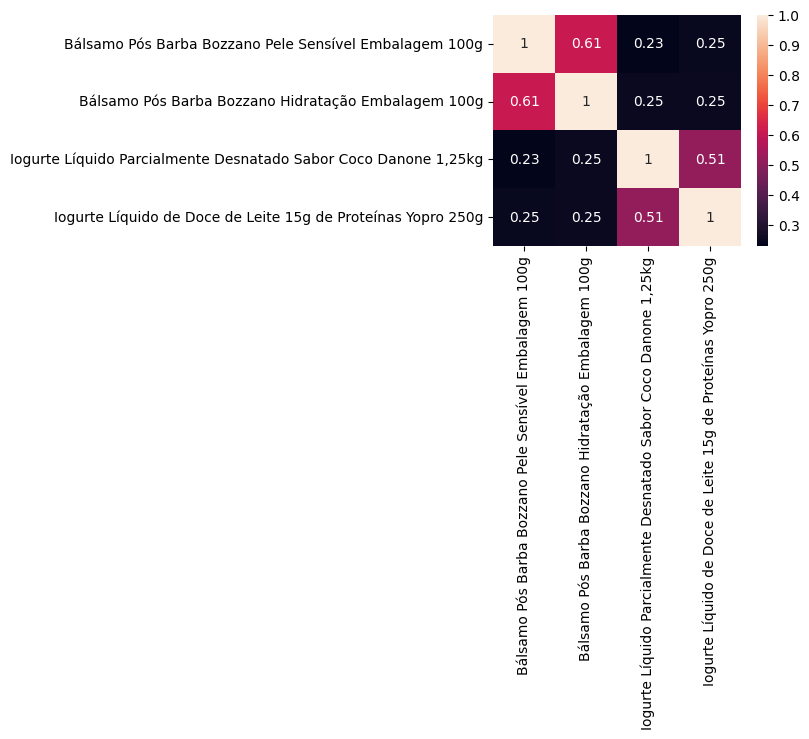

In [28]:
tags_set_morumbi = [ # coop---jd-morumbi-jd-morumbi.json
    # "Bálsamo Pós Barba Bozzano Pele Sensível Embalagem 100g"
    {"product": ["Bálsamo"], "brand": ["Pós Barba"], "features": ["Bozzano", "Pele", "Sensível"], "size": ["100g"]},
    # "Bálsamo Pós Barba Bozzano Hidratação Embalagem 100g"
    {"product": ["Bálsamo"], "brand": ["Pós Barba", "Bozzano"], "features": ["Hidratação"], "size": ["100g"]},
    # "Iogurte Líquido Parcialmente Desnatado Sabor Coco Danone 1,25kg"
    {"product": ["Iogurte"], "features": ["Líquido", "Parcialmente", "Desnatado", "Coco"], "brand": ["Danone"], "size": ["1,25kg"]},
    # "Iogurte Líquido de Doce de Leite 15g de Proteínas Yopro 250g"
    {"product": ["Iogurte"], "features": ["Líquido", "Doce de Leite", "Proteínas"], "size": ["15g", "250g"], "brand": ["Yopro"]}
]

labels = [
    "Bálsamo Pós Barba Bozzano Pele Sensível Embalagem 100g",
    "Bálsamo Pós Barba Bozzano Hidratação Embalagem 100g",
    "Iogurte Líquido Parcialmente Desnatado Sabor Coco Danone 1,25kg",
    "Iogurte Líquido de Doce de Leite 15g de Proteínas Yopro 250g"
]

similarity_matrix_example = np.array(
    [
        [similarity(tags1, tags2) for tags2 in tags_set_morumbi]
        for tags1 in tags_set_morumbi
    ]
)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(similarity_matrix_example, annot=True, xticklabels = labels, yticklabels=labels, ax=ax)

## ~~Build graph~~

In [7]:
# from tqdm import tqdm

In [8]:
# similarity_matrix_f16 = np.empty((len(data), len(data)), dtype=np.float16)
# for id1, prod1 in tqdm(data.items()):
#     for id2, prod2 in data.items():
#         # set within-market similarities to 0
#         if id2market[id1] == id2market[id2]:
#             similarity_matrix_f16[id1][id2] = np.float16(0)
#             continue
#         # for different markets, compute similarity (or replicate since similarity matrix is simmetric)  
#         similarity_matrix_f16[id1][id2] = np.float16(similarity(prod1['tags'], prod2['tags'])) if id1 <= id2 else similarity_matrix_f16[id2][id1]

**NO WAY, TOO LONG!!!**

## Connectity matrix (for agglomerative clustering)

In [18]:
from scipy.sparse import csr_array, csr_matrix 
from sys import getsizeof
from tqdm import tqdm

In [22]:
conn_matrix = np.ones((len(data), len(data)), dtype=np.int8)
for id_list in market2id.values():
    for id1 in tqdm(id_list):
        for id2 in id_list:
            conn_matrix[id1][id2] = 0

# conn_matrix = csr_array(conn_matrix)
# print("after converting to sparse matrix:", getsizeof(conn_matrix))

## (n_samples,1) data matrix

In [30]:
X = np.array([d['tags'] for d in data.values()], dtype=object)

In [31]:
X[0]

{'product': ['Energético'],
 'features': ['Energy', 'Drink', 'Coco', 'Açaí', 'Edition', 'Red'],
 'brand': ['Bull'],
 'size': ['250ml']}

# Try different clustering methods

## single-linkage

In [10]:
from sklearn.cluster import AgglomerativeClustering

In [23]:
singleleakage = AgglomerativeClustering(
    n_clusters=None,
    metric=distance,
    connectivity=conn_matrix,
    linkage="single"
)

In [32]:
y = singleleakage.fit_predict(X)

TypeError: float() argument must be a string or a real number, not 'dict'